<h3>Импортируем все необходимые библиотеки</h3>

In [488]:
import pandas as pd
import numpy as np
import asyncio
import telethon.sync
import nest_asyncio
nest_asyncio.apply()
import aiohttp
import aiomoex
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3
import sys
import time
import pymorphy2
from string import punctuation
import yfinance as yf
from datetime import datetime
from IPython.display import clear_output
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import scipy.stats
# import spacy
# from spacy.lang.ru.examples import sentences
from deep_translator import (GoogleTranslator,
                             PonsTranslator,
                             LingueeTranslator,
                             MyMemoryTranslator,
                             YandexTranslator,
                             DeepL,
                             QCRI,
                             single_detection,
                             batch_detection)

<h3>Сбор сообщений из телеграмм-каналов</h3>

In [2]:
api_id = 1923089
api_hash = '8e526e12df9137207e2f7b966924a246'

client = telethon.sync.TelegramClient('Kostya3', api_id, api_hash)

loop = asyncio.get_event_loop()

#Создаем пустые листы и задаём количество наблюдений в выборке равное n*количество телеграмм каналов 
texts =[]
dates = []
n=int(input())

#Собираем посты из канала РынкиДеньгиВласть
async def rdv():
    messages = await client.get_messages('https://t.me/AK47pfl', n)
    i=0
    while i<len(messages):
        text = messages[i].text
        date = messages[i].date
        date = date.replace(tzinfo=None)
        texts.append(text)
        dates.append(date)
        i+=1
    return(texts, dates)
async with client:
    client.loop.run_until_complete(rdv())

#Собираем посты из канала Сигналы РЦБ
async def signals():
    messages = await client.get_messages('https://t.me/cbrstocks', n)
    i=0
    while i<len(messages):
        text = messages[i].text
        date = messages[i].date
        date = date.replace(tzinfo=None)
        texts.append(text)
        dates.append(date)
        i+=1
    return(texts, dates)
async with client:
    client.loop.run_until_complete(signals())

#Формируем базу данных
tab = pd.DataFrame({'Дата и время': dates, 'Сообщение': texts})
tab = tab.set_index('Дата и время')
tab = tab.sort_index()
tab.to_csv("raw_text")

15000


<h3>Сбор тикеров акций, торгуемых в режиме TQBR</h3>

<em>Для выборки были взяты не все акции, торгующиеся на Мосбирже, а лишь 268 акций, торгуемых в режиме T+0</em>
<p><em>Это наиболее популярные акции, которые часто упоминаются в соцсетях</em></p>

In [3]:
#достаем тикеры акций и их названия с сайта мосбиржи и сохраняем в таблицу
async def shares_func():
    request_url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json"
    arguments = {"securities.columns": ("SECID," "SHORTNAME," "SECNAME")}

    async with aiohttp.ClientSession() as session:
        iss = aiomoex.ISSClient(session, request_url, arguments)
        data = await iss.get()
        shares = pd.DataFrame(data["securities"])
        shares.to_csv('shares')

asyncio.run(shares_func())

In [4]:
shares = pd.read_csv('shares')
shares = shares.drop('Unnamed: 0', axis = 'columns')
shares['NewName'] = shares.SHORTNAME.map(lambda x: x[0: x.find(' ')] if ' ' in x else x)
shares['NewName'] = shares.NewName.map(lambda x: x[0: x.find('-')] if '-' in x else x)
shares['NewName'] = shares.NewName.map(lambda x: x[0: x.find('.')] if '.' in x else x)
shares['NewName'] = shares['NewName'].replace('Система', 'АФК Система')
shares['NewName'] = shares['NewName'].replace('FIVE', 'X5 RetailGroup')
shares['NewName'] = shares['NewName'].replace('FIXP', 'FixPrice')
shares['NewName'] = shares['NewName'].replace('Yandex', 'Яндекс')
shares['NewName'] = shares['NewName'].replace('+МосЭнерго', 'МосЭнерго')
secid = list(shares['SECID'])
shortname = list(shares['NewName'])   
secid_and_shortname = dict(zip(secid, shortname))

<h3>Предобработка текста</h3>

<p>В данной части работы ведётся предварительная обработка текта, для того, чтобы избавить результаты анализа текста от искажений</p>
<p>Основные шаги предобработки:</p>
<ol>
    <li>Удаление неинформативных символов</li>
    <li>Замена тикеров на краткие названия, которые удобно искать в тексте</li>
    <li>Удаление ссылок и хэштегов</li>
    <li>Создание обучающей и тестовой выборки вручную путём присваивания положительного, отрицательного и нейтрального тона</li>
</ol>

In [5]:
#импортируем данные
raw_data = pd.read_csv("raw_text")
raw_data = raw_data.set_index('Дата и время')
raw_data = raw_data.dropna()

#удаляем ссылки
raw_data['Сообщение'] = raw_data['Сообщение'].str.replace("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|\
                                                        (?:%[0-9a-fA-F][0-9a-fA-F]))+", '', case=False) 
# удаляем эмодзи
raw_data['Сообщение']=raw_data['Сообщение'].str.replace("["u"\U0001F600-\U0001F64F"  
                    u"\U0001F300-\U0001F5FF" 
                    u"\U0001F680-\U0001F6FF" 
                    u"\U0001F1E0-\U0001F1FF" 
                    u"\U00002500-\U00002BEF" 
                    u"\U00002702-\U000027B0"
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u"\U00010000-\U0010ffff"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u200d"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    u"\ufe0f"
                    u"\u3030"
                    "]+", "", regex = True)

#Удаляем различный информационный мусор
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('[*()@,__•#]', " ", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('\n\n', " ", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('[\n]', "", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('  ', " ", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('AK47pfl', "", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('[*[(+\\\]\t]', "", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('[:]', "", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('[%]', "процентов", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('[$"]', "долларов", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('долларов', " ", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('AK47PFLCHAT', "", regex = True)
raw_data['Сообщение']=raw_data['Сообщение'].str.replace('\u200b', "", regex = True)
raw_data["Сообщение"] = raw_data["Сообщение"].str.replace('[', "", regex = True)
raw_data["Сообщение"] = raw_data["Сообщение"].str.replace(']', "", regex = True)
raw_data["Сообщение"] = raw_data["Сообщение"].str.replace('RDVPREMIUMbot', "", regex = True)

# заменяем тикеры на краткие названия
raw_data["Сообщение"] = raw_data["Сообщение"].replace(secid_and_shortname, regex=True)

# экспортируем данные
raw_data = raw_data.dropna()
raw_data.to_csv("cleaned_data.csv")

<h3>Выгружаем данные по ценам</h3>

<p>Данные грузятся за 4 года, поэтому не все компании попадут в выборку, однако это исправляется простым изменением периода</p>
<p>Было решено создать массив данных по всем возможным компаниям, чтобы не грузить данные по каждой компании отдельно</p>


In [489]:
d = {}
for name in shares['SECID']:
    d[name] = yf.download(name + '.ME', '2017-04-01', '2021-09-30') #Здесь меняем период
    if d.get(name).empty == True:
        d.pop(name)
    else:
        for i in range(0,d.get(name).shape[0]-1):
            d.get(name).loc[d.get(name).index[i+1],'Rit'] = np.log(d.get(name).iloc[i+1, 4]/d.get(name).iloc[i, 4])
        d.get(name)['Rit_norm'] = d.get(name)['Rit'].rolling(window=60).mean()
        d.get(name)['𝜀'] = (d.get(name)['Rit'] - d.get(name)['Rit_norm'])*100
        d.get(name)['AR'] = d.get(name)['𝜀'].rolling(window=60, min_periods=1).mean()
        d.get(name)['CAR'] = d.get(name)['AR'].rolling(window=15, center=True).sum()
        #Считаем t-статистику
        d.get(name)['for_s2'] = (d.get(name)['𝜀']-d.get(name)['AR'])**2/59
        d.get(name)['s2'] = d.get(name)['for_s2'].rolling(window=60, min_periods=1).sum()
        d.get(name)['t'] = d.get(name)['AR']/(((d.get(name)['s2']/60))**(1/2))
        #Выгружаем критические статистики
        d.get(name)['t_crit_left_001'] = scipy.stats.t.ppf(0.01, 59)
        d.get(name)['t_crit_right_001'] = scipy.stats.t.ppf(1-0.01, 59)
        d.get(name)['t_crit_left_005'] = scipy.stats.t.ppf(0.05, 59)
        d.get(name)['t_crit_right_005'] = scipy.stats.t.ppf(1-0.05, 59)
        d.get(name)['t_crit_left_01'] = scipy.stats.t.ppf(0.1, 59)
        d.get(name)['t_crit_right_01'] = scipy.stats.t.ppf(1-0.1, 59)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SLEN.ME: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SMLT.ME: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 comp

<h3>Подсчитываем количество упоминаний в соцсетях</h3>

<p>Подсчет ведется по всем компаниям</p>

In [7]:
data=pd.read_csv('cleaned_data.csv')
data['Дата и время']=pd.to_datetime(data['Дата и время']).apply(lambda x: x.date())
for key in d.keys():
    Comp_name = shares[shares['SECID'] == key]['NewName'].values[0]
    mention = data[data["Сообщение"].str.contains(Comp_name, na=False)]
    data['is' + key] = 0
    for i in mention.index:
        data.loc[data.index[i],'is'+key] = 1
data.to_csv('maped_data.csv')

In [8]:
cnt={}
for key in d.keys():
    cnt[key] = pd.pivot_table(data, values=('is' + key), index=['Дата и время'], aggfunc=np.sum)

<h3>Перевод сообщений с русского на английский</h3>
<p>Это необходимо для того, чтобы была возможность использовать VADER-анализ тональности текста, который работает только для английского языка</p>

In [169]:
tr_data = pd.read_csv('maped_data.csv')
tr_data=tr_data.drop('Unnamed: 0', axis = 'columns')
tr_data = tr_data.drop(tr_data[tr_data['Сообщение']==' '].index)
tr_data = tr_data.reset_index()
tr_data['message'] = ''

In [209]:
for i in range(0, tr_data.shape[0]-1):
    print(i)
    try:
        tr_data.iloc[i, tr_data.columns.get_loc('message')]=(
            GoogleTranslator(source='auto', target='en').translate(text=tr_data.iloc[i, tr_data.columns.get_loc('Сообщение')]))
    except:
        tr_data.iloc[i, tr_data.columns.get_loc('message')] = ''
    clear_output()
# tr_data.to_csv('filename.csv')

<h3>Анализ тональности текста</h3>
<p>На данном этапе используется простой метод анализа тональности текста, у которого есть существенные недостатки:</p>
<ol>
    <li>Невозможность анализировать русскоязычные тексты => теряется точность после перевода</li>
    <li>VADER был обучен не на столь узкоспециализированных данных</li>
    <li>Невозможность анализировать предложение с учётом упоминания конкретной компании</li>
</ol>
<p>Тем не менее такой метод даёт не самую плохую точность 57% верно размеченных сообщений с учётом модифицированной методологии. Кроме того, его не нужно специально обучать => не требуется большая размеченная выборка.</p>
<p>О методологии:</p>
<ol>
    <li>Было принято решение классифицировать данные, исходя из уравнения Score_neu|pos*compound*10</li>
    <li>Таким образом учитывается не только тональность, но и эмоциональная сила, с которой подаётся текст</li>
    <li>Отсекающим значением было выбрано +-0.75 для позитивного и негативного счёта соответственно</li>
    <li>Всё, что внутри этого отрезка, считается нейтральным</li>
    <li>Счёт присуждается любой компании из списка из-за ограничений модели</li>
</ol>

In [356]:
tran_data = pd.read_csv('tr_data.csv')
tran_data=tran_data.drop('Unnamed: 0', axis = 'columns')
tran_data = tran_data.drop(tran_data[tran_data['message']==' '].index)
tran_data = tran_data.dropna()
tran_data = tran_data.reset_index()
tran_data=tran_data.drop('index', axis = 'columns')

In [357]:
sia = SentimentIntensityAnalyzer()
neg = []
neu = []
pos = []
comp = []
for i in range(0, tran_data.shape[0]):
    translated=tran_data['message'][i]
    neg.append(sia.polarity_scores(translated).get('neg'))
    neu.append(sia.polarity_scores(translated).get('neu'))
    pos.append(sia.polarity_scores(translated).get('pos'))
    comp.append(sia.polarity_scores(translated).get('compound'))
scores = pd.DataFrame({'neg': neg, 'neu': neu, 'pos': pos, 'comp': comp})
scores['score'] = 0
for i in range(0,scores.shape[0]):
    if scores.iloc[i,scores.columns.get_loc('neg')]*scores.iloc[i,scores.columns.get_loc('comp')]*10<-0.75:
        scores.loc[scores.index[i],'score']=-1
    elif scores.iloc[i,scores.columns.get_loc('pos')]*scores.iloc[i,scores.columns.get_loc('comp')]*10>0.75:
        scores.loc[scores.index[i],'score']=1
    else:
        scores.loc[scores.index[i],'score']=0
tran_data['neg_score'] = 0
tran_data['neu_score'] = 0
tran_data['pos_score'] = 0
for i in scores[scores['score']==-1].index:
        tran_data.loc[tran_data.index[i],'neg_score'] = 1
for i in scores[scores['score']==0].index:
        tran_data.loc[tran_data.index[i],'neu_score'] = 1
for i in scores[scores['score']==1].index:
        tran_data.loc[tran_data.index[i],'pos_score'] = 1

In [461]:
cnt_neg_score = pd.pivot_table(tran_data, values=('neg_score'), index=['Дата и время'], aggfunc=np.sum)
cnt_neu_score = pd.pivot_table(tran_data, values=('neu_score'), index=['Дата и время'], aggfunc=np.sum)
cnt_pos_score = pd.pivot_table(tran_data, values=('pos_score'), index=['Дата и время'], aggfunc=np.sum)

cnt_neg_score.index=pd.to_datetime(cnt_neg_score.index)
cnt_neu_score.index=pd.to_datetime(cnt_neu_score.index)
cnt_pos_score.index=pd.to_datetime(cnt_pos_score.index)

cnt_score=pd.DataFrame({'neg': cnt_neg_score['neg_score'], 'neu': cnt_neu_score['neu_score'], 
                        'pos': cnt_pos_score['pos_score']}, index=cnt_neg_score.index)

cnt_score['d_neg'] = cnt_score['neg']/(cnt_score['neg']+cnt_score['neu']+cnt_score['pos'])
cnt_score['d_neu'] = cnt_score['neu']/(cnt_score['neg']+cnt_score['neu']+cnt_score['pos'])
cnt_score['d_pos'] = cnt_score['pos']/(cnt_score['neg']+cnt_score['neu']+cnt_score['pos'])

<h3>Графические анализ по компаниям</h3>

Введите тикер акции
BELU
Период анализа:
С какой даты вы хотели бы посмотреть статистику?
2021-01-01
По какую дату вы хотели бы посмотреть статистику?
2021-10-30


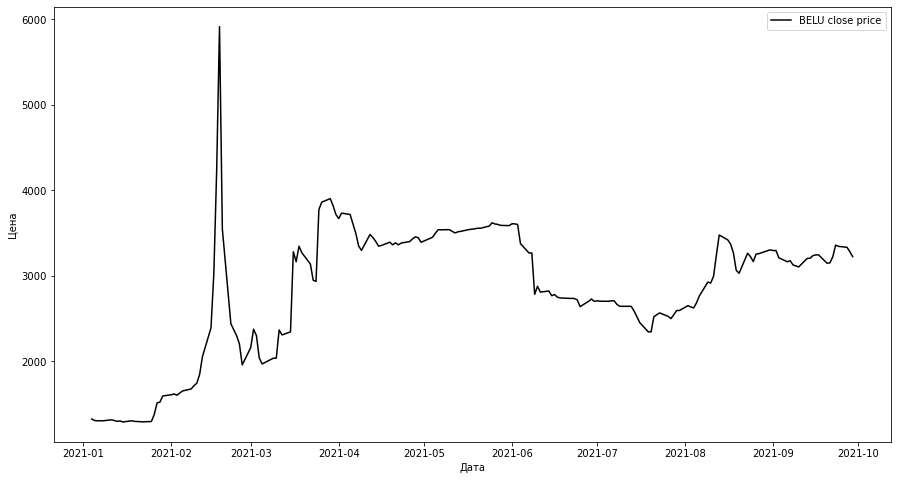

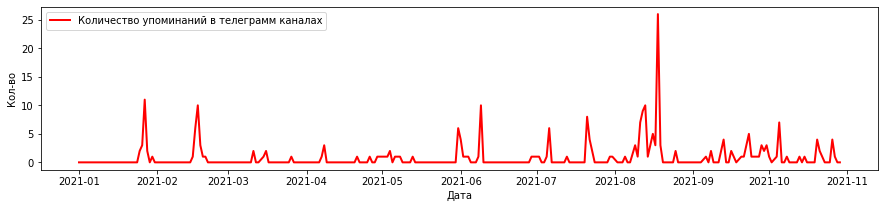

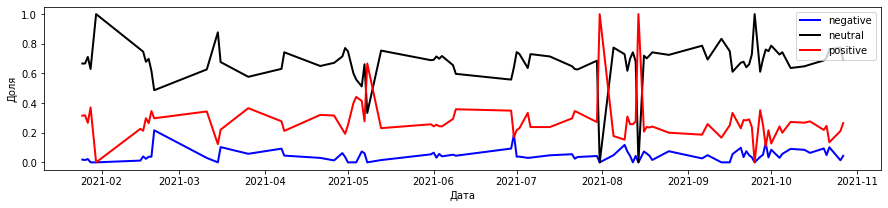

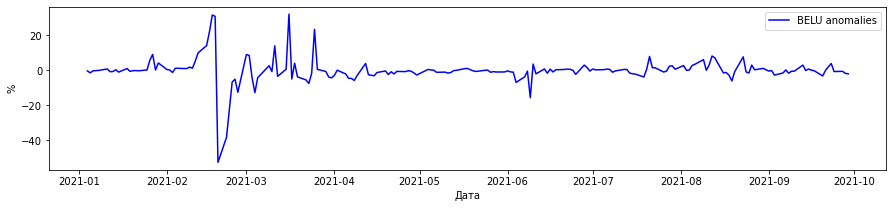

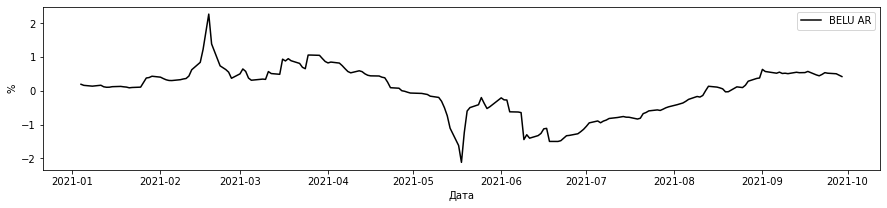

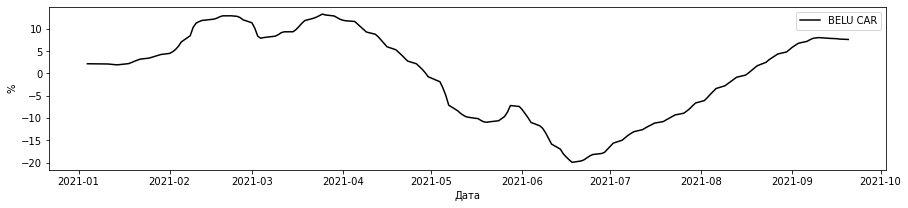

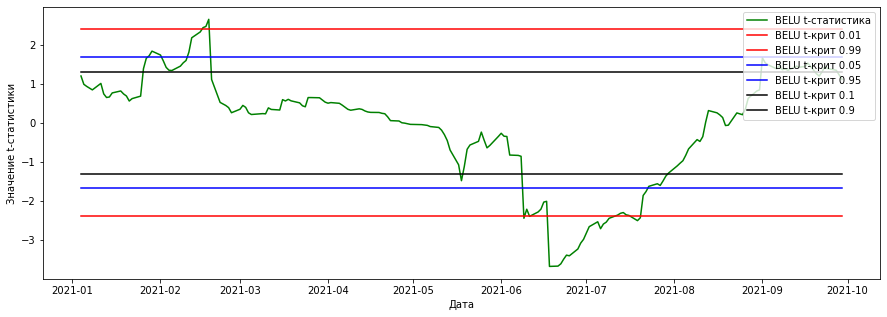

Матрица корреляций цены закрытия и упоминаний:
           mentions     price
mentions  1.000000  0.126469
price     0.126469  1.000000
Матрица корреляций t-статистики и упоминаний:
           mentions    t-stat
mentions  1.000000  0.069581
t-stat    0.069581  1.000000


In [503]:
print('Введите тикер акции')
company = str(input())
print('Период анализа:')
print('С какой даты вы хотели бы посмотреть статистику?')
period_start = str(input())
print('По какую дату вы хотели бы посмотреть статистику?')
period_end = str(input())

if datetime.strptime(period_end, '%Y-%m-%d').date()<datetime.strptime(period_start, '%Y-%m-%d').date():
    print('Последняя дата периода должна быть больше первой')
else:
    idx = cnt.get(company)[cnt.get(company)['is'+company]>0].index.to_list()
    
    #цена закрытия
    plt.figure(figsize = (15, 8))
    plt.plot(d.get(company)[period_start:period_end]['Adj Close'], color = "black", label = company + " close price")
    plt.ylabel('Цена')
    plt.xlabel('Дата')
    plt.legend()
    plt.show()
    
    #Упоминания компании
    plt.figure(figsize = (15, 3))
    plt.plot(cnt.get(company)[datetime.strptime(period_start, '%Y-%m-%d').date():
                              datetime.strptime(period_end,'%Y-%m-%d').date()]['is'+company], 
                              color='red', linewidth=2, label = 'Количество упоминаний в телеграмм каналах')
    plt.ylabel('Кол-во')
    plt.xlabel('Дата')
    plt.legend()
    plt.show()
    
    #Доля положительных/нейтральных/негативных сообщений
    plt.figure(figsize = (15, 3))
    plt.plot(cnt_score[cnt_score.index.isin(idx)==True][period_start:period_end]['d_neg'], 
                              color='blue', linewidth=2, label = 'negative')
    plt.plot(cnt_score[cnt_score.index.isin(idx)==True][period_start:period_end]['d_neu'], 
                              color='black', linewidth=2, label = 'neutral')
    plt.plot(cnt_score[cnt_score.index.isin(idx)==True][period_start:period_end]['d_pos'], 
                              color='red', linewidth=2, label = 'positive')
    plt.ylabel('Доля')
    plt.xlabel('Дата')
    plt.legend(loc='upper right')
    plt.show()    
    
    #Аномальная доходность
    plt.figure(figsize = (15, 3))
    plt.plot(d.get(company)[period_start:period_end]['𝜀'], color = "blue", label = company + " anomalies")
    plt.ylabel('%')
    plt.xlabel('Дата')
    plt.legend()
    plt.show()
    
    #Средняя аномальная доходность
    plt.figure(figsize = (15, 3))
    plt.plot(d.get(company)[period_start:period_end]['AR'], color = "black", label = company + " AR")
    plt.ylabel('%')
    plt.xlabel('Дата')
    plt.legend()
    plt.show()
    
    #Кумулятивная аномальная доходность
    plt.figure(figsize = (15, 3))
    plt.plot(d.get(company)[period_start:period_end]['CAR'], color = "black", label = company + " CAR")
    plt.ylabel('%')
    plt.xlabel('Дата')
    plt.legend()
    plt.show()

    plt.figure(figsize = (15, 5))
    plt.plot(d.get(company)[period_start:period_end]['t'], color = "green", 
             label = company + " t-статистика")
    plt.plot(d.get(company)[period_start:period_end]['t_crit_left_001'], color = "red", 
             label = company + " t-крит 0.01")
    plt.plot(d.get(company)[period_start:period_end]['t_crit_right_001'], color = "red", 
             label = company + " t-крит 0.99")
    plt.plot(d.get(company)[period_start:period_end]['t_crit_left_005'], color = "blue", 
             label = company + " t-крит 0.05")
    plt.plot(d.get(company)[period_start:period_end]['t_crit_right_005'], color = "blue", 
             label = company + " t-крит 0.95")
    plt.plot(d.get(company)[period_start:period_end]['t_crit_left_01'], color = "black", 
             label = company + " t-крит 0.1")
    plt.plot(d.get(company)[period_start:period_end]['t_crit_right_01'], color = "black", 
             label = company + " t-крит 0.9")
    plt.ylabel('Значение t-статистики')
    plt.xlabel('Дата')
    plt.legend(loc='upper right')
    plt.show()
    
    ment = cnt.get(company)[datetime.strptime(period_start, '%Y-%m-%d').date():
                              datetime.strptime(period_end,'%Y-%m-%d').date()]['is' + company]
    price = d.get(company)[period_start:period_end]['Adj Close']
    t = d.get(company)[period_start:period_end]['t']
    df1 = pd.DataFrame({'mentions': ment, 'price': price})
    df2 = pd.DataFrame({'mentions': ment, 't-stat': t})
    
    print('Матрица корреляций цены закрытия и упоминаний:\n',df1.corr())
    print('Матрица корреляций t-статистики и упоминаний:\n',df2.corr())